In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
from sklearn.model_selection import train_test_split
import utils as utils

import numpy as np
import tensorflow as tf
import keras
from keras import layers

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Input, Concatenate, Dropout

from gensim.models import Word2Vec

from keras.callbacks import Callback, ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score

from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joshuasegal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Read the CSV file into a DataFrame
df = pd.read_csv('text_entailment_dataset/train.csv')

# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42)  # Shuffle with fixed seed for reproducibility

# Split the data into training and validation sets
train_df, validation_df = train_test_split(df, test_size=0.1, random_state=42)

# Write the training and validation DataFrames to separate CSV files
train_df.to_csv('text_entailment_dataset/train_data.csv', index=False)
validation_df.to_csv('text_entailment_dataset/validation_data.csv', index=False)


train_dataset = df = pd.read_csv('text_entailment_dataset/train_data.csv')
validation_dataset = df = pd.read_csv('text_entailment_dataset/validation_data.csv')
test_dataset = df = pd.read_csv('text_entailment_dataset/test_data.csv')


In [3]:
train_dataset.head()

,premise,hypothesis,label
0,a dog chases a red ball.,A cute dog paly with a ball.,0
1,A carefully dressed you boy is nonverbally com...,A young boy dressed in a potato sack is trying...,2
2,A black and white dog jumps in the snow.,The dogs are leaping into the snow.,0
3,A man singing and playing guitar on a busy sid...,A man is performing on a city sidewalk,0
4,A man holding a rifle next to his brown dog.,A man is climbing a tree.,2


In [4]:
train_dataset.shape

(494424, 3)

In [5]:
validation_dataset.head()

,premise,hypothesis,label
0,A young couple looking at different types and ...,a couple is looking,0
1,A man in a purple had climbs a rocky wall with...,A man is going to the temple.,2
2,A group of friends playing cards and trying to...,The people are playing a card game.,0
3,People looking at fish at an aquarium.,People looking at fish.,0
4,An older lady blowing out a 9 and a 0 number c...,A woman drinks coffee while driving.,2


In [6]:
validation_dataset.shape

(54937, 3)

In [7]:
test_dataset.head()

,premise,hypothesis
0,This church choir sings to the masses as they ...,The church has cracks in the ceiling.
1,This church choir sings to the masses as they ...,The church is filled with song.
2,This church choir sings to the masses as they ...,A choir singing at a baseball game.
3,"A woman with a green headscarf, blue shirt and...",The woman is young.
4,"A woman with a green headscarf, blue shirt and...",The woman is very happy.


In [8]:
test_dataset.shape

(9824, 2)

In [9]:
train_dataset[["premise"]] = train_dataset[["premise"]].astype(str)
train_dataset["premise"] = train_dataset["premise"].apply(utils.change_lower)
train_dataset["premise"] = train_dataset["premise"].apply(utils.clean_data)
train_dataset["premise"] = train_dataset["premise"].apply(utils.remover)

test_dataset[["hypothesis"]] = train_dataset[["hypothesis"]].astype(str)
train_dataset["hypothesis"] = train_dataset["hypothesis"].apply(utils.change_lower)
train_dataset["hypothesis"] = train_dataset["hypothesis"].apply(utils.clean_data)
train_dataset["hypothesis"] = train_dataset["hypothesis"].apply(utils.remover)

validation_dataset[["premise"]] = validation_dataset[["premise"]].astype(str)
validation_dataset["premise"] = validation_dataset["premise"].apply(utils.change_lower)
validation_dataset["premise"] = validation_dataset["premise"].apply(utils.clean_data)
validation_dataset["premise"] = validation_dataset["premise"].apply(utils.remover)

validation_dataset[["hypothesis"]] = validation_dataset[["hypothesis"]].astype(str)
validation_dataset["hypothesis"] = validation_dataset["hypothesis"].apply(utils.change_lower)
validation_dataset["hypothesis"] = validation_dataset["hypothesis"].apply(utils.clean_data)
validation_dataset["hypothesis"] = validation_dataset["hypothesis"].apply(utils.remover)

test_dataset[["premise"]] = test_dataset[["premise"]].astype(str)
test_dataset["premise"] = test_dataset["premise"].apply(utils.change_lower)
test_dataset["premise"] = test_dataset["premise"].apply(utils.clean_data)
test_dataset["premise"] = test_dataset["premise"].apply(utils.remover)

test_dataset[["hypothesis"]] = test_dataset[["hypothesis"]].astype(str)
test_dataset["hypothesis"] = test_dataset["hypothesis"].apply(utils.change_lower)
test_dataset["hypothesis"] = test_dataset["hypothesis"].apply(utils.clean_data)
test_dataset["hypothesis"] = test_dataset["hypothesis"].apply(utils.remover)

In [10]:
# X_train = train_dataset['premise'] + train_dataset['hypothesis']
# X_Val = validation_dataset['premise'] + validation_dataset['hypothesis']
# X_test = test_dataset['premise'] + test_dataset['hypothesis']


In [11]:
# Tokenize text data
sentences = train_dataset['premise'].tolist() + train_dataset['hypothesis'].tolist()
sentences = [sentence.split() for sentence in sentences]  # Split sentences into words

word2vec_model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, workers=4)

tokenizer = Tokenizer(num_words=len(word2vec_model.wv.key_to_index) + 1)
tokenizer.fit_on_texts(train_dataset['premise'].tolist() + train_dataset['hypothesis'].tolist())

train_premise_sequences = tokenizer.texts_to_sequences(train_dataset['premise'].tolist())
train_hypothesis_sequences = tokenizer.texts_to_sequences(train_dataset['hypothesis'].tolist())

val_premise_sequences = tokenizer.texts_to_sequences(validation_dataset['premise'].tolist())
val_hypothesis_sequences = tokenizer.texts_to_sequences(validation_dataset['hypothesis'].tolist())

test_premise_sequences = tokenizer.texts_to_sequences(test_dataset['premise'].tolist())
test_hypothesis_sequences = tokenizer.texts_to_sequences(test_dataset['hypothesis'].tolist())


max_premise_length = max(len(seq) for seq in train_premise_sequences)
max_hypothesis_length = max(len(seq) for seq in train_hypothesis_sequences)
max_sequence_length = max(max_premise_length, max_hypothesis_length)


train_premise_sequences = pad_sequences(train_premise_sequences, maxlen=max_sequence_length, padding='post')
train_hypothesis_sequences = pad_sequences(train_hypothesis_sequences, maxlen=max_sequence_length, padding='post')

val_premise_sequences = pad_sequences(val_premise_sequences, maxlen=max_sequence_length, padding='post')
val_hypothesis_sequences = pad_sequences(val_hypothesis_sequences, maxlen=max_sequence_length, padding='post')

test_premise_sequences = pad_sequences(test_premise_sequences, maxlen=max_sequence_length, padding='post')
test_hypothesis_sequences = pad_sequences(test_hypothesis_sequences, maxlen=max_sequence_length, padding='post')

embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv.key_to_index:
        embedding_matrix[i] = word2vec_model.wv[word]

print("Size of Vocabulary:", len(tokenizer.word_index))
print("Size of Train Premise Sequences:", len(train_premise_sequences))
print("Size of Train Hypothesis Sequences:", len(train_hypothesis_sequences))


Size of Vocabulary: 34718
Size of Train Premise Sequences: 494424
Size of Train Hypothesis Sequences: 494424


In [12]:
print(train_premise_sequences.shape)

(494424, 45)


In [13]:
# # Generate word embeddings for each word in the sequences and pad sequences
# train_vectorized_data = []
# for seq in train_sequences:
#     # Generate embeddings for individual words in the sequence
#     word_embeddings = [word2vec_model.wv[word_index] for word_index in seq]
#     # Pad the sequence of embeddings to the maximum length
#     padded_embeddings = pad_sequences([word_embeddings], maxlen=max_sequence_length, padding='post', dtype='float32')[0]
#
#     # Append padded embeddings to vectorized_data
#     train_vectorized_data.append(padded_embeddings)
#
# # Convert vectorized data to numpy array
# train_vectorized_data = np.array(train_vectorized_data)
#
# print("Vectorized Train Data Shape:", train_vectorized_data.shape)

In [14]:
# # Generate embeddings for validation set
# val_vectorized_data = []
# for seq in val_sequences:
#     word_embeddings = [word2vec_model.wv[word_index] if word_index in word2vec_model.wv else np.zeros(word2vec_model.vector_size) for word_index in seq]
#
#     padded_embeddings = pad_sequences([word_embeddings], maxlen=max_sequence_length, padding='post', dtype='float32')[0]
#
#     val_vectorized_data.append(padded_embeddings)
#
# val_vectorized_data = np.array(val_vectorized_data)
#
# print("Vectorized Validation Data Shape:", val_vectorized_data.shape)

In [15]:
# # Generate embeddings for test set
# test_vectorized_data = []
# for seq in test_sequences:
#     word_embeddings = [word2vec_model.wv[word_index] if word_index in word2vec_model.wv else np.zeros(word2vec_model.vector_size) for word_index in seq]
#
#     padded_embeddings = pad_sequences([word_embeddings], maxlen=max_sequence_length, padding='post', dtype='float32')[0]
#
#     test_vectorized_data.append(padded_embeddings)
#
# test_vectorized_data = np.array(test_vectorized_data)
#
# print("Vectorized Test Data Shape:", test_vectorized_data.shape)


In [16]:
train_labels = train_dataset["label"]
validation_labels = validation_dataset["label"]

# Convert to one-hot encoded format
num_classes = len(set(train_labels))  # Calculate the number of classes
train_labels = to_categorical(train_labels, num_classes=num_classes)
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

print("train label shape:", train_labels.shape)
print("val label shape:", validation_labels.shape)

train label shape: (494424, 3)
val label shape: (54937, 3)


In [17]:
def data_generator(premise_sequences, hypothesis_sequences, labels, batch_size):
    '''
    Returns a data generator to be used for training or validation.

    Yields batches of separate premise and hypothesis sequences (tokenized) and corresponding labels.

    Args:
      premise_sequences: List of tokenized premise sequences
      hypothesis_sequences: List of tokenized hypothesis sequences
      labels: List of corresponding labels
      batch_size: Number of sequences per batch (premise and hypothesis pairs)

    Returns:
      Data generator
    '''

    num_samples = len(premise_sequences)
    num_batches = (num_samples + batch_size - 1) // batch_size  # Calculate total number of batches
    idx = 0  # Initialize index to keep track of where we are in the dataset

    while True:  # Loop indefinitely to generate batches
        batch_premise_sequences = premise_sequences[idx:idx+batch_size]
        batch_hypothesis_sequences = hypothesis_sequences[idx:idx+batch_size]
        batch_labels = labels[idx:idx+batch_size]

        # Yield the batch (separate premise and hypothesis sequences)
        yield ([batch_premise_sequences, batch_hypothesis_sequences], batch_labels)

        # Move to the next batch
        idx += batch_size

        # If we reach the end of the dataset, start over
        if idx + batch_size > num_samples:
            idx = 0

In [18]:
# print(train_vectorized_data.shape[1], ",", train_vectorized_data.shape[2])

In [19]:
batch_size = 32
train_generator = data_generator(train_premise_sequences, train_hypothesis_sequences, train_labels, batch_size)
val_generator = data_generator(val_premise_sequences, val_hypothesis_sequences, validation_labels, batch_size)

steps_per_epoch = len(train_premise_sequences) // batch_size
validation_steps = len(val_premise_sequences) // batch_size

In [20]:
sample_batch_X, sample_batch_y = next(train_generator)
print(sample_batch_X[0].shape)
print(sample_batch_X[1].shape)
print(sample_batch_y.shape)

sample_batch_X, sample_batch_y = next(val_generator)
print(sample_batch_X[0].shape)
print(sample_batch_X[1].shape)
print(sample_batch_y.shape)

(32, 45)
(32, 45)
(32, 3)
(32, 45)
(32, 45)
(32, 3)


In [21]:
class MetricsCallback(Callback):
    def __init__(self, val_premise_sequences, val_hypothesis_sequences, val_labels):
        super(MetricsCallback, self).__init__()
        self.val_premise_sequences = val_premise_sequences
        self.val_hypothesis_sequences = val_hypothesis_sequences
        self.val_labels = val_labels
        self.metrics = {'epoch': [], 'precision': [], 'recall': [], 'f1': [], 'val_loss': [], 'val_accuracy': [], 'loss': [], 'accuracy': []}

    def on_epoch_end(self, epoch, logs=None):
        val_loss, val_accuracy = self.model.evaluate(
            [self.val_premise_sequences, self.val_hypothesis_sequences], self.val_labels, verbose=0)
        val_pred = self.model.predict([self.val_premise_sequences, self.val_hypothesis_sequences])
        val_pred_classes = np.argmax(val_pred, axis=1)  # Convert probabilities to classes

        precision = precision_score(np.argmax(self.val_labels, axis=1), val_pred_classes, average='weighted')
        rec all = recall_score(np.argmax(self.val_labels, axis=1), val_pred_classes, average='weighted')
        f1 = f1_score(np.argmax(self.val_labels, axis=1), val_pred_classes, average='weighted')

        self.metrics['epoch'].append(epoch + 1)
        self.metrics['precision'].append(precision)
        self.metrics['recall'].append(recall)
        self.metrics['f1'].append(f1)
        self.metrics['val_loss'].append(val_loss)
        self.metrics['val_accuracy'].append(val_accuracy)
        self.metrics['loss'].append(logs['loss'])
        self.metrics['accuracy'].append(logs['accuracy'])

        print("Epoch {}: Validation Precision = {:.4f}, Recall = {:.4f}, F1 Score = {:.4f}, Val Loss = {:.4f}, Val Accuracy = {:.4f}".format(epoch + 1, precision, recall, f1, val_loss, val_accuracy))

In [22]:
metrics_callback = MetricsCallback(val_premise_sequences, val_hypothesis_sequences, validation_labels)

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

In [23]:
#Best Hyperparameters: {'learning_rate': 0.001000649183264211, 'lstm_units': 67, 'dropout_rate': 0.23348344445560876, 'activation': 'relu', 'dense_units': 89}
# Best Hyperparameters: {'dropout_rate_lstm': 0.2783331011414365, 'dropout_rate_dense': 0.13998996632720118}

# Define embedding layer based on embedding matrix (assuming pre-trained Word2Vec)
embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
                            output_dim=embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            trainable=False)

# Input layers for premise and hypothesis sequences
premise_input = Input(shape=(max_sequence_length,))
hypothesis_input = Input(shape=(max_sequence_length,))

# Embedding layers for premise and hypothesis inputs
embedded_premise = embedding_layer(premise_input)
embedded_hypothesis = embedding_layer(hypothesis_input)

# LSTM layers for premise and hypothesis sequences
premise_lstm = LSTM(units=67, dropout=0.2783331011414365)(embedded_premise)
hypothesis_lstm = LSTM(units=67, dropout=0.2783331011414365)(embedded_hypothesis)

# Concatenate LSTM outputs
combined_lstm = Concatenate()([premise_lstm, hypothesis_lstm])

# Final dense layers for prediction with 3 outputs (entailment, neutral, contradiction)
dense1 = Dense(units=89, activation='relu')(combined_lstm)
dense1_dropout = Dropout(0.13998996632720118)(dense1)  # Add dropout after dense layer
output = Dense(units=3, activation='softmax')(dense1_dropout)

# Define the model with premise and hypothesis sequence inputs
model = tf.keras.Model(inputs=[premise_input, hypothesis_input], outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001000649183264211),
              loss='categorical_crossentropy',  # Use categorical cross-entropy for one-hot encoded labels
              metrics=['accuracy'])

In [24]:
print(len(train_premise_sequences))
print(len(val_premise_sequences))

494424
54937


In [25]:
# # subset_train_data = (train_premise_sequences[:1000], train_hypothesis_sequences[:1000])
# # subset_val_data = (val_premise_sequences[:500], val_hypothesis_sequences[:500])
# subset_train_data = (train_premise_sequences[:50000], train_hypothesis_sequences[:50000])
# subset_val_data = (val_premise_sequences[:5000], val_hypothesis_sequences[:5000])
#
# # subset_train_labels = train_labels[:1000]
# # subset_validation_labels = validation_labels[:500]
# subset_train_labels = train_labels[:50000]
# subset_validation_labels = validation_labels[:5000]
#
# # Define the search space
# space = [
#     Real(0.1, 0.5, name='dropout_rate_lstm'),  # Dropout rate for LSTM layers
#     Real(0.1, 0.5, name='dropout_rate_dense')  # Dropout rate for dense layer
# ]
#
# # Define the objective function
# @use_named_args([
#     Real(0.1, 0.5, name='dropout_rate_lstm'),  # Dropout rate for LSTM layers
#     Real(0.1, 0.5, name='dropout_rate_dense')  # Dropout rate for dense layer
# ])
#
# #Best Hyperparameters: {'learning_rate': 0.001000649183264211, 'lstm_units': 67, 'dropout_rate': 0.23348344445560876, 'activation': 'relu', 'dense_units': 89}
#
# def objective(dropout_rate_lstm, dropout_rate_dense):
#     # Define and compile the model with hyperparameters
#     embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
#                                 output_dim=embedding_matrix.shape[1],
#                                 weights=[embedding_matrix],
#                                 trainable=False)
#
#     premise_input = Input(shape=(max_sequence_length,))
#     hypothesis_input = Input(shape=(max_sequence_length,))
#
#     embedded_premise = embedding_layer(premise_input)
#     embedded_hypothesis = embedding_layer(hypothesis_input)
#
#     premise_lstm = LSTM(units=67, dropout=dropout_rate_lstm)(embedded_premise)
#     hypothesis_lstm = LSTM(units=67, dropout=dropout_rate_lstm)(embedded_hypothesis)
#
#     combined_lstm = Concatenate()([premise_lstm, hypothesis_lstm])
#
#     dense1 = Dense(units=89, activation='relu')(combined_lstm)
#     dense1_dropout = Dropout(dropout_rate_dense)(dense1)  # Add dropout after dense layer
#     output = Dense(units=3, activation='softmax')(dense1_dropout)
#
#     model = tf.keras.Model(inputs=[premise_input, hypothesis_input], outputs=output)
#
#     #use tf.keras.optimizers.legacy.Adam
#     model.compile(optimizer=tf.keras.optimizers.legacy.Adam  (learning_rate=0.001000649183264211),
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])
#
#     # Train the model
#     # use model.fit
#     early_stopping = EarlyStopping(monitor='val_loss', patience=3)
#     history = model.fit(subset_train_data, subset_train_labels,
#                         epochs=10,
#                         validation_data=(subset_val_data, subset_validation_labels),
#                         callbacks=[early_stopping, metrics_callback],
#                         verbose=1)
#
#     # Return the validation loss
#     return np.min(history.history['val_loss'])
#
# # Run Bayesian optimization
# result = gp_minimize(objective, space, n_calls=10, random_state=42)
#
# # Get the best hyperparameters
# best_hyperparameters = dict(zip(['dropout_rate_lstm', 'dropout_rate_dense'], result.x))
# print("Best Hyperparameters:", best_hyperparameters)


In [26]:
# model.summary()

In [27]:
history = model.fit(train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=10,
                              validation_data=val_generator,
                              validation_steps=validation_steps,
                              callbacks=[metrics_callback, checkpoint])

Epoch 1/10
1717/1717 [==============================] - 9s 5ms/step
Epoch 1: Validation Precision = 0.5976, Recall = 0.5955, F1 Score = 0.5945, Val Loss = 0.8812, Val Accuracy = 0.5955

Epoch 1: val_loss improved from inf to 0.88121, saving model to best_model.h5
15450/15450 [==============================] - 283s 18ms/step - loss: 0.9527 - accuracy: 0.5428 - val_loss: 0.8812 - val_accuracy: 0.5955
Epoch 2/10
1717/1717 [==============================] - 10s 6ms/step
Epoch 2: Validation Precision = 0.6073, Recall = 0.6051, F1 Score = 0.6046, Val Loss = 0.8599, Val Accuracy = 0.6051

Epoch 2: val_loss improved from 0.88121 to 0.85996, saving model to best_model.h5
15450/15450 [==============================] - 276s 18ms/step - loss: 0.8914 - accuracy: 0.5853 - val_loss: 0.8600 - val_accuracy: 0.6051
Epoch 3/10
1717/1717 [==============================] - 9s 5ms/step
Epoch 3: Validation Precision = 0.6145, Recall = 0.6095, F1 Score = 0.6079, Val Loss = 0.8537, Val Accuracy = 0.6095

Epoch

In [28]:
epochs = metrics_callback.metrics['epoch']
precision = metrics_callback.metrics['precision']
recall = metrics_callback.metrics['recall']
f1 = metrics_callback.metrics['f1']
accuracy = metrics_callback.metrics['accuracy']
loss = metrics_callback.metrics['loss']
val_accuracy = metrics_callback.metrics['val_accuracy']
val_loss = metrics_callback.metrics['val_loss']

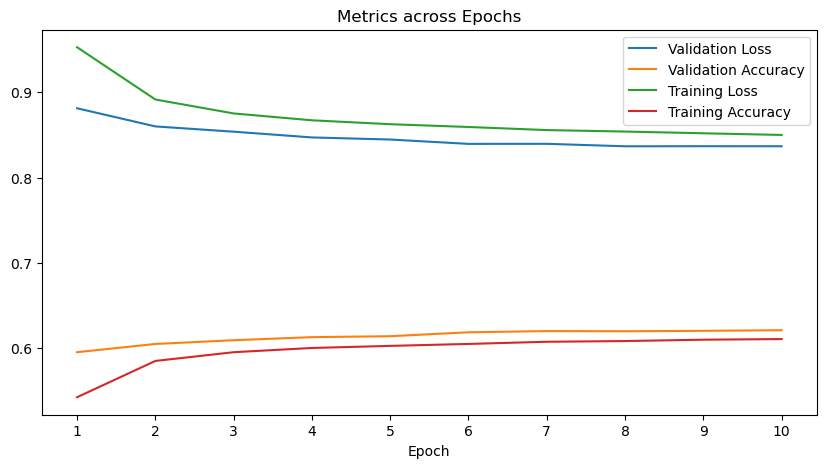

In [29]:
# Plot all four metrics on one graph
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_loss, label='Validation Loss')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, accuracy, label='Training Accuracy')

plt.title('Metrics across Epochs')
plt.xlabel('Epoch')
plt.xticks(epochs)
plt.legend()
plt.savefig("LSTM_RNN_val_loss_acc.pdf")  # Save the plot before showing
plt.show()


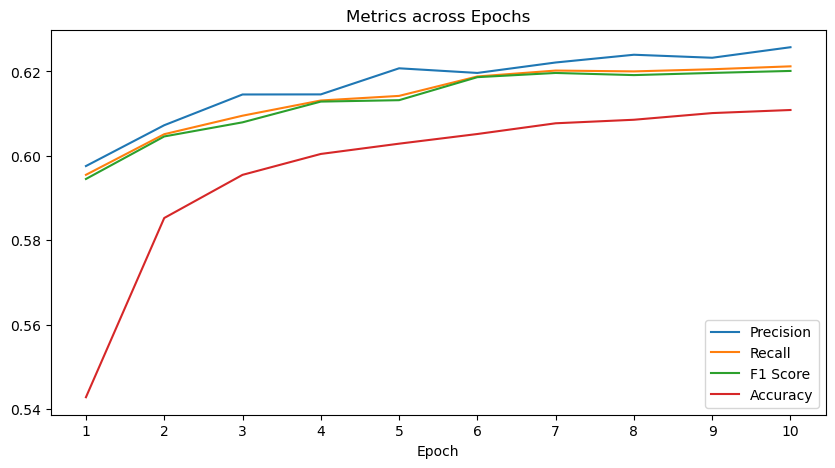

In [30]:
# Plot all four metrics on one graph
plt.figure(figsize=(10, 5))
plt.plot(epochs, precision, label='Precision')
plt.plot(epochs, recall, label='Recall')
plt.plot(epochs, f1, label='F1 Score')
plt.plot(epochs, accuracy, label='Accuracy')

plt.title('Metrics across Epochs')
plt.xlabel('Epoch')
plt.xticks(epochs)
plt.legend()
plt.savefig("LSTM_RNN_PRFA.pdf")
plt.show()